In [1]:
!pip install -q tf-models-official==2.3.0

     |████████████████████████████████| 849kB 9.8MB/s 
     |████████████████████████████████| 174kB 17.4MB/s 
     |████████████████████████████████| 36.7MB 86kB/s 
     |████████████████████████████████| 1.1MB 49.9MB/s 
     |████████████████████████████████| 102kB 15.9MB/s 
     |████████████████████████████████| 358kB 48.5MB/s 


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

# Prepare Dataset

In [3]:
batch_size = 8

In [4]:
# Set up tokenizer to generate Tensorflow dataset
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [5]:
dataset, info = tfds.load('aeslc', with_info=True,
                          as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/aeslc/1.0.0.incomplete7PV8M8/aeslc-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/aeslc/1.0.0.incomplete7PV8M8/aeslc-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/aeslc/1.0.0.incomplete7PV8M8/aeslc-test.tfrecord
Dataset aeslc downloaded and prepared to /root/tensorflow_datasets/aeslc/1.0.0. Subsequent calls will reuse this data.


In [6]:
def encode_sentence(em, sub):
    em_tokens = ['[CLS]'] + tokenizer.tokenize(em.numpy()) + ['[SEP]']
    sub_tokens = ['[CLS]'] + tokenizer.tokenize(sub.numpy()) + ['[SEP]']
    return tokenizer.convert_tokens_to_ids(em_tokens), tokenizer.convert_tokens_to_ids(sub_tokens)

def bert_encode(em, sub):
    enc_em, enc_sub = tf.py_function(encode_sentence, [em, sub], [tf.int32, tf.int64])
    enc_em.set_shape([None])
    enc_sub.set_shape([None])

    return enc_em, enc_sub

def filter_max_length(x, y, max_length=511):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [7]:
train_dataset = dataset['train'].map(bert_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
# train_dataset = train_dataset.cache()
train_dataset = train_dataset.padded_batch(batch_size)
# train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = dataset['validation'].map(bert_encode)
val_dataset = val_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
# train_dataset = train_dataset.cache()
val_dataset = val_dataset.padded_batch(batch_size)
# train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Positional Encodings

In [8]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [9]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

# Scaled dot product attention

In [10]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

# Multi-headed attention

In [11]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

# Feed-forward network

In [12]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Decoder layer

In [13]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

# Decoder

In [14]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers=8, d_model=768, num_heads=12, dff=2, target_vocab_size=10000,
               maximum_position_encoding=512, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

# Encoder

In [15]:
hub_model_name = "bert_en_uncased_L-12_H-768_A-12"
hub_encoder = hub.KerasLayer(f"https://tfhub.dev/tensorflow/{hub_model_name}/2",
                             trainable=True)

# Masks

In [16]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [17]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [18]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = tf.cast(tf.math.logical_not(tf.math.equal(inp, 0)), tf.int32)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

# Transformer

In [19]:
class Transformer(tf.keras.Model):
  def __init__(self, target_vocab_size):
    super(Transformer, self).__init__()

    self.encoder = hub_encoder
    self.decoder = Decoder(target_vocab_size=target_vocab_size)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
    
    enc_output = self.encoder([inp,
                               enc_padding_mask,
                               tf.cast(tf.math.equal(inp, 0), tf.int32)], training=training)[1]  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [20]:
transformer = Transformer(30522)

In [21]:
# for inp, tar in train_dataset:
#     enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar[:, :-1])
#     predictions, _ = transformer(inp,
#                                  tar[:, :-1],
#                                  True,
#                                  enc_padding_mask,
#                                  combined_mask,
#                                  dec_padding_mask)
#     print(predictions)
#     break

# Scheduler


In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [23]:
learning_rate = CustomSchedule(768)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

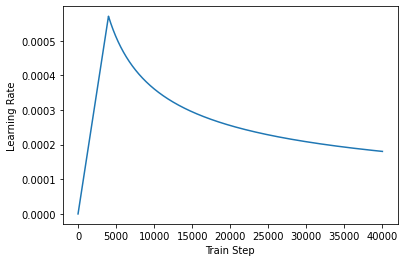

In [24]:
temp_learning_rate_schedule = CustomSchedule(768)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss Functions

In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [26]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [27]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

# Training

In [28]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp,
                                     tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))


@tf.function(input_signature=train_step_signature)
def val_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    predictions, _ = transformer(inp,
                                 tar_inp,
                                 False,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

    val_loss(loss)
    val_accuracy(accuracy_function(tar_real, predictions))

In [30]:
print('training')
num_epochs = 5
metrics_names = ['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'] 
for epoch in range(num_epochs):
    # start = time.time()

    print("\nepoch {}/{}".format(epoch+1, num_epochs))

    progBar = tf.keras.utils.Progbar(None, stateful_metrics=metrics_names)

    train_loss.reset_states()
    train_accuracy.reset_states()

    val_loss.reset_states()
    val_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        values = [('train_loss', train_loss.result()), ('train_accuracy',train_accuracy.result())]
        progBar.update(batch*batch_size, values=values) 

    for (batch, (inp, tar)) in enumerate(val_dataset):
        val_step(inp, tar)

    values = [('train_loss', train_loss.result()), ('train_accuracy',train_accuracy.result()),
              ('val_loss', val_loss.result()), ('val_accuracy', val_accuracy.result())]

    progBar.update(batch*batch_size, values=values) 

training

epoch 1/5
   1880/Unknown - 1287s 685ms/step - train_loss: 6.8940 - train_accuracy: 0.1583 - val_loss: 6.9983 - val_accuracy: 0.1558
epoch 2/5
   1880/Unknown - 1286s 684ms/step - train_loss: 6.8008 - train_accuracy: 0.1562 - val_loss: 7.2216 - val_accuracy: 0.1532
epoch 3/5
   1880/Unknown - 1284s 683ms/step - train_loss: 6.7605 - train_accuracy: 0.1557 - val_loss: 7.0737 - val_accuracy: 0.1532
epoch 4/5
   1880/Unknown - 1283s 682ms/step - train_loss: 6.5239 - train_accuracy: 0.1558 - val_loss: 7.1323 - val_accuracy: 0.1532
epoch 5/5
   1880/Unknown - 1290s 686ms/step - train_loss: 6.4196 - train_accuracy: 0.1558 - val_loss: 7.1274 - val_accuracy: 0.1532